Install pytorch_grad_cam https://github.com/jacobgil/pytorch-grad-cam

In [23]:
#!pip install grad-cam

In [1]:
import os
import numpy as np
import pandas as pd

import torch
import torchvision

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

import copy
from imutils import paths
from pathlib import Path
import os
import time
import copy
import pickle
from tqdm import tqdm

import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from PIL import Image, ImageDraw
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

In [2]:
import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset


class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root ='', train=True, transform=None, loader=default_loader, download=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [3]:
def imshow(inp, title=None, figsize=(20,8)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [4]:
# Define data transforms, based on SOTA repos.
# get_feats transforms are used for feature extraction later-on
def makeDefaultTransforms(img_crop_size=224, img_resize=256):
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(img_crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(img_resize),
            transforms.CenterCrop(img_crop_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'get_feats': transforms.Compose([
            transforms.Resize(img_resize),
            transforms.CenterCrop(img_crop_size),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    return data_transforms

### Load test (val) data

In [5]:
data_transform = makeDefaultTransforms()
test_data = Cub2011(train=False,root='./',transform=data_transform['test'])

Files already downloaded and verified


In [6]:
test_loaders = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

In [7]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(test_loaders))

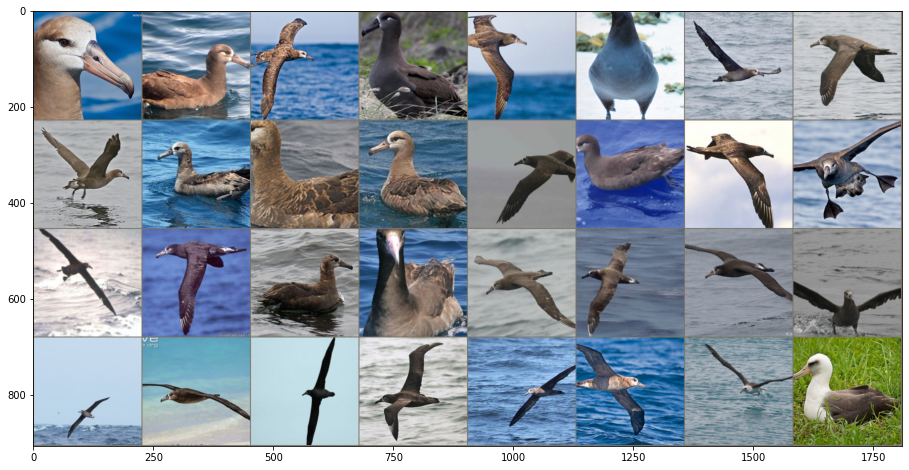

In [8]:
out = torchvision.utils.make_grid(inputs)
imshow(out)

### External data repo

In [9]:
data_dir = r'C:\Users\user\Desktop\birds data\web-bird'
# Setup data loaders with augmentation transforms
web_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transform['test'])
web_data_loader = torch.utils.data.DataLoader(web_data, batch_size=32, shuffle=False, num_workers=0)


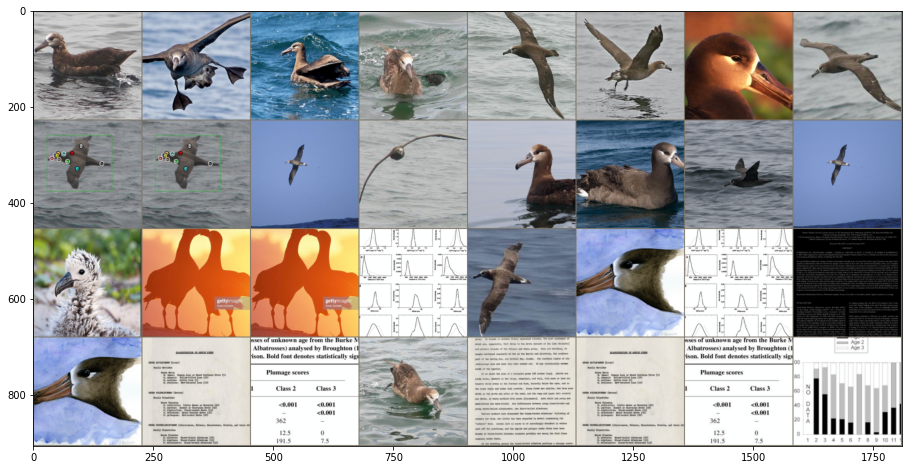

In [10]:
inputs, classes = next(iter(web_data_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [11]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


## Evaluate classifier and get features + proba

In [12]:
# Load the best model from file
# model_ is a resnet152 network that I trained on CUB dataset 
model_file = r'C:\Users\user\Desktop\birds data\caltech_birds-master\models\classification\resnet34-3d\caltech_birds_resnet34_full.pth'
model_ = torch.load(model_file).to(device)

model_ft = copy.deepcopy(model_)
target_layers = [model_ft.layer4[-1]]
cam = GradCAM(model=model_ft, target_layers=target_layers, use_cuda=torch.cuda.is_available())

In [13]:
# Get the feature extraction module from the pretrained model_
modules=list(model_.children())[:-1]
resnet152=nn.Sequential(*modules)
for p in resnet152.parameters():
    p.requires_grad = False

In [14]:
import torch.nn as nn
softmax = nn.Softmax(dim=-1)
'''
extract_feature_maps: evaluates the model on the given dataloader, and outputs, the predictions, + their softmax probabilities, 
+ the extracted features
'''
def extract_feature_maps(model, dataloader, device):
    was_training = model.training
    model.eval()

    img_paths = []
    
    print('Commencing predictions and feature extraction minibatch..', end='')
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if i % 25 == 0:
                print('{}..'.format(i), end='')
            

            inputs = inputs.to(device)
            labels = labels.to(device)


            out = model(inputs)
            _, preds = torch.max(out, 1)
            feats = resnet152(inputs)

            if i == 0:
                labels_truth = labels.cpu().numpy()
                labels_pred = preds.cpu().numpy()
                scores_pred = softmax(out).cpu().numpy()
                features = resnet152(inputs).squeeze().cpu().numpy()

            else:
                labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
                labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))
                scores_pred= np.concatenate((scores_pred,softmax(out).cpu().numpy()))
                features= np.concatenate((features,resnet152(inputs).squeeze().cpu().numpy()))

            #fc_feature_extractions[i] = fc_feature_extractions[i].squeeze().cpu().numpy()

    return {'y_true' : labels_truth, 
            'y_pred' : labels_pred,
            'features' : features,# np.concatenate(fc_feature_extractions,axis=0).squeeze(),
            'proba': scores_pred }

In [15]:
# Get outputs from test set
output_test = extract_feature_maps(model=model_, dataloader=test_loaders, device=device)
#print(classification_report(y_true=output_test['y_true'], y_pred=output_test['y_pred']))

Commencing predictions and feature extraction minibatch..0..25..50..75..100..125..150..175..

In [16]:
# Get outputs from external set
output_external = extract_feature_maps(model=model_, dataloader=web_data_loader, device=device)
#print(classification_report(y_true=output_external['y_true'], y_pred=output_external['y_pred']))

Commencing predictions and feature extraction minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..

## Post-hoc explanibility - Utility Score

#### Get extracted features using pretrained Faster RNN

In [18]:
'''
Given an image x, we use a state-of-the-art RCNN model [24] to derive
salient region proposals that correspond to an object or object part. These region proposals are passed
through M to obtain the corresponding visual features denoted as W.
'''
# This is the function that generates region proposals using a pretrained Faster-RCNN RPN
# Here I am using the PRetrained RPN as it is (pretrained on COCO dataset), you can change the pretrained network to use your
# custom model that you trained on CUB data: check this: https://discuss.pytorch.org/t/custom-resnet50-weights-on-pytorch-faster-rcnn-backbone/141429

rp_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True, num_classes=91, pretrained_backbone=True)
def get_rpn_w(x_id,web_data,rp_model,resnet152):

    '''
    inputs: 
        - x_id: index of the querried image (from Xc)
        - web_data: external data repo
        - rp_model: pretrained region proposal network: takes as input tensor image, and returns BBs
        - resnet152: feature extraction module of the classifier trained on CUB
    '''
    rp_model.eval()
    W = []
    result =  rp_model([web_data[x_id][0]])
    for bbox in result[-1]['boxes']:
        x1, x2, x3, x4 = map(int, bbox)
        cropped_resized_img = data_transform['get_feats'](web_data[x_id][0][:,x2:x4,x1:x3]) 
        W.append(resnet152(torch.unsqueeze(cropped_resized_img,0).to(device)).squeeze().cpu().numpy().reshape(1,-1))
    return np.concatenate(W)
    

#### Extract features from saliency regions identified by GradCam

In [48]:
'''
Let Xc→c¯ be the set of images whose class label has been misclassified from c to c¯. Then Sc→c¯ is
the set of regions in Xc→c¯ obtained from the saliency maps of Grad-CAM. The regions in Sc→c¯ are
passed through M, and the output of the last layer before the classification layer form their visual
features, denoted as U. 
'''
# The following function computes GradCam from test_data[mask], crops the BB based on the obtained saliency maps, 
#then transforms them(Make sure to use the same transforms used to train/test the model) and feed them to the model 
#to extract the feature vectors U
def get_gradcam_u(mask,test_data,targets,resnet152):
    '''
    inputs: 
        - mask: indices of the set of images whose class label has been misclassified from c to c¯ (from test_data) 
        - test_data: test/validation data, the set used to identify Xc→c
        - targets: the class id with respect to which gradcam will be computed
        - resnet152: feature extraction module of the classifier trained on CUB
    '''
    U = []
    for idx in mask:
        grayscale_cam = cam(input_tensor= test_data[idx][0].unsqueeze(0).to(device), targets=targets)
        grayscale_cam = (grayscale_cam * 255).astype("uint8").squeeze()
        threshMap = cv2.threshold(grayscale_cam.astype("uint8"), 0.5, 1,cv2.THRESH_BINARY| cv2.THRESH_OTSU)[1]
        cnts = cv2.findContours(threshMap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        for c in cnts:
            x,y,w,h = cv2.boundingRect(c)
            cropped_resized_img = data_transform['get_feats'](test_data[idx][0][:,x:x+w,y:y+h]) 
            U.append(resnet152(torch.unsqueeze(cropped_resized_img,0).to(device)).squeeze().cpu().numpy().reshape(1,-1))
    return np.concatenate(U)

In [49]:
# Computes Delta using gradcam + RPN(Equation 6)
def get_delta(U,W,epsilon=1e-6):
    delta = 0
    for u in U:
        zu = max([-np.log(1-(np.dot(u,w).item()/(np.linalg.norm(u)*np.linalg.norm(w)))+epsilon) for w in W])
        delta += zu
    return delta

### Get utilty score

In [50]:
# Given x_idx the index of the querried image (x from Xc),
# and the class in question c, this loop computes the utility score
'''
for x ∈ Xc do
    for c¯ ∈ C¯ do
        β(x, c, c¯) ← Calculate under-representation score as in Eq. 2.
        Sc→c¯ ← Derive concepts caused misclassifications.
        ∆(Sc→c¯, x) ← Calculate availability of concepts Sc→c¯.
    end
    utility(x) = sum c¯∈C¯ [β(x, c, c¯) × ∆(Sc→c¯, x))]
end

'''
x_idx = 0
c = 87

betas = []
deltas = []

W = get_rpn_w(x_idx,web_data,rp_model,resnet152)
fx = output_external['features'][x_idx,:].reshape(1,-1)

mask = np.where(output_test['y_true'] == c)[0]
fc = np.mean(output_test['features'][mask,:],axis=0).reshape(-1,1) # average of all test(val in the paper)features from class c


for ci in np.unique(output_test['y_pred'][mask]):# for c¯ ∈ C¯ do:
    if ci == c:
        continue
    betas.append((np.dot(fx,fc).item()/(np.linalg.norm(fx)*np.linalg.norm(fc)))*np.exp(output_external['proba'][x_idx,ci]))
 
    targets = [ClassifierOutputTarget(ci)]# from gradcam computation
    misc_mask = np.where(output_test['y_pred'][mask]==ci)[0] # samples from class c misclassified as ci (Xc→ci)
    U = get_gradcam_u(mask[misc_mask],test_data,targets,resnet152)
    deltas.append(get_delta(U,W,epsilon=10e-6))

utility = np.dot(betas,deltas).item()

In [51]:
utility

12.436276209805106